# Imports

In [117]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# For saving the scaler.
import joblib

### Importing data

In [94]:
df = pd.read_csv("GlobalLandTemperaturesByCountry.csv")

# Preprocessing

In [95]:
# I will only be using the data from one country.
# This will make the task in hand more fine tuned for a specific geographical location,
# thereby making it a better model

df = df[df['Country'] == 'India']

In [96]:
df.head() # Checking the values

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
243695,1796-01-01,17.044,2.044,India
243696,1796-02-01,19.193,1.359,India
243697,1796-03-01,22.319,2.125,India
243698,1796-04-01,27.233,1.510,India
243699,1796-05-01,30.035,1.338,India


In [97]:
# Dropping any null values in the dataset as incomplete or absent rows of data will lead to further complications in the model.
# It will also degrade the model performance.
df.dropna(axis=0, inplace=True)

In [98]:
# Turning the date into a more suitable format for the neural network to compute.
df['Date'] = pd.to_datetime(df['dt'])
df.set_index('Date', inplace=True)

# Reshaping the temperature matrix
data = df['AverageTemperature'].values
data = data.reshape(-1, 1)

# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)


In [99]:
# As the feature or the input to predict new temperature is temperature from previous days.
# I will be storing the previous 60 days of the day I will be predicting or training the model with.
def create_sequences(data, prev_days):
    x = []
    y = []
    for i in range(len(data) - prev_days):
        x.append(data[i:i+prev_days])
        y.append(data[i+prev_days])
    return np.array(x), np.array(y)

prev_days = 60  # Number of previous data_rows to use for predicting the next day
x, y = create_sequences(scaled_data, prev_days)

In [100]:
# Splitting it into training and testing datasets.
# Size of train and test df is 80%, 20%
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Making the model

In [101]:
# The main model which will predict the temperature.
# I have used LSTM layers as they are good when dates are involved making this an RNN (Recurrent Neural Network)

model = tf.keras.Sequential(

    layers=[

        # Starting with an LSTM layer
        tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),

        # Dropout layer signifying how much percentage of nodes to ignore
        # Helps us to avoid patterns in noisy data (not usefull patterns in predicting temperature)
        # Allows the model to generalize better over the whole dataset.
        tf.keras.layers.Dropout(0.2),

        # Another LSTM layer for good measure
        tf.keras.layers.LSTM(units=50, return_sequences=False),

        # Another dropout layer
        tf.keras.layers.Dropout(0.2),

        # Normal Dense layer which helps us to use all the data from previous nodes into each of the existing one
        tf.keras.layers.Dense(25),

        # Dense layer with 1 unit as the last temperature (scaled) will be computed here
        tf.keras.layers.Dense(1)
    ]
)

# Compiling the model
# Using Adam optimizer as it is an overall good performer
# Mean Absolute Error as the loss function as it is suitable for regression problems
model.compile(tf.keras.optimizers.Adam(0.0001), loss='mean_squared_error')


In [109]:
# Training the model

model.fit(x_train, y_train, batch_size=32, epochs=20)


Epoch 1/20
62/62 [==============================] - 2s 28ms/step - loss: 0.0273
Epoch 2/20
62/62 [==============================] - 1s 24ms/step - loss: 0.0261
Epoch 3/20
62/62 [==============================] - 2s 25ms/step - loss: 0.0254
Epoch 4/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0253
Epoch 5/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0249
Epoch 6/20
62/62 [==============================] - 2s 24ms/step - loss: 0.0236
Epoch 7/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0239
Epoch 8/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0238
Epoch 9/20
62/62 [==============================] - 1s 24ms/step - loss: 0.0234
Epoch 10/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0231
Epoch 11/20
62/62 [==============================] - 1s 23ms/step - loss: 0.0228
Epoch 12/20
62/62 [==============================] - 1s 24ms/step - loss: 0.0233
Epoch 13/20
62/62 [==================

# Prediction and Evaluation

In [110]:
# Making predictions on the test data
predictions = model.predict(x_test)

# scaling it back to normal scale 
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 0s 13ms/step


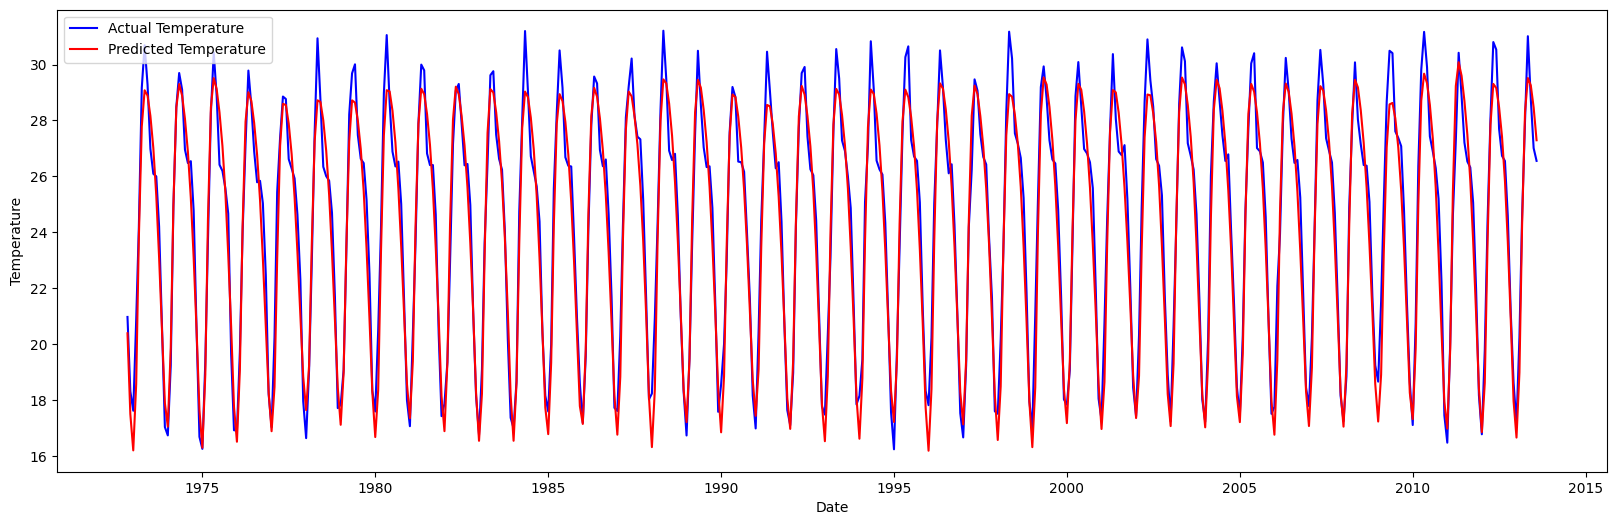

In [111]:
import matplotlib.pyplot as plt

# Plotting the results after prediction
plt.figure(figsize=(20,6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Temperature')
plt.plot(df.index[-len(predictions):], predictions, color='red', label='Predicted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


# Conclusion

Summing up the graph depicts how close our predicted values were to the actual ones. Of course the model can be better with a little more fine tuning alongside more data as it would be good if we could take into account other factors.

If you see the dataset, we even don't have the temperature of each day. Instead we only have the temperature of the first of the month.
Having the temperatures of all the days would have made this an even better model

Uses -

- We could match actual temperature with previously predicted temperature (supposing the model has reached near perfection) to see what might be wrong that there is such a difference in the projected data (for eg forest fire can lead to a slight increase in the temperature of a place)
- We can also obviously use this to forecast weather.
- Researchers can also see into the model to check how much weightage the model is giving to each of the past dates too predict the next day's temperature which might help us find weather patterns.

# Saving the model

In [118]:
# Saving the model for later use

model.save("model.keras")

#  Saving the scaler values
# This is necessary as the scaler is also finetuned to this temperature data

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']